In [33]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point


In [34]:
# replace the file paths with your own file paths
file_path_point_table = r'../Datasets/crash_data.csv'
file_path_polygon_shapefile = r'../Datasets/NYC_Block_Groups_2016_2020_Shapefile/NYC_Block_Groups_2016_2020.shp'

In [35]:
df_point = pd.read_csv(file_path_point_table)
df_point.sample()

,crash_date,crash_time,latitude,longitude,location,on_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,...,zip_code,cross_street_name,contributing_factor_vehicle_3,vehicle_type_code2,vehicle_type_code_3,contributing_factor_vehicle_4,vehicle_type_code_4,off_street_name,contributing_factor_vehicle_5,vehicle_type_code_5
87036,2023-11-24,18:59,40.667366,-73.92274,"{'latitude': '40.667366', 'longitude': '-73.92...",UNION STREET,1,0,1,0,...,11212.0,NaN,NaN,NaN,NaN,NaN,NaN,RALPH AVENUE,NaN,NaN


In [36]:
gdf_poly = gpd.read_file(file_path_polygon_shapefile)

<AxesSubplot: >

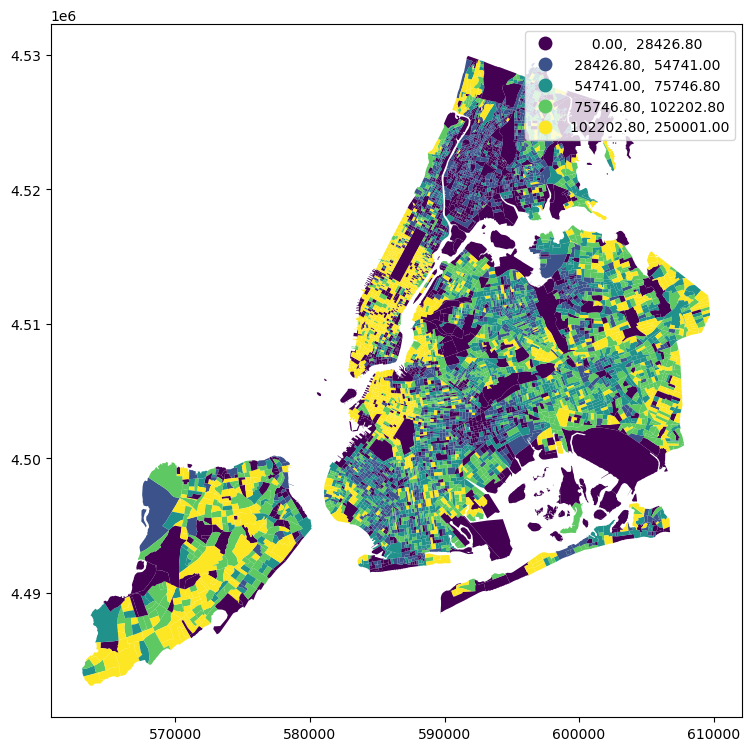

In [37]:
fig, ax = plt.subplots(figsize=(15, 9))  # Set figure size

gdf_poly.plot(column="MHI",
                   cmap='viridis',
                   legend=True,
                   scheme="quantiles",
                   ax=ax)

In [1]:
# gdf_poly.explore()

In [39]:
# this line adds a geometry to the table. To build a point geometry you will need latitude and longitude
# Make sure the check the name of longitude and latitude columns. Replace names if you need.
df_point['geometry'] = df_point.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
# now we convert the Pandas dataframe to a Geopandas geodataframe
gdf_point = gpd.GeoDataFrame(df_point, geometry='geometry', crs="EPSG:4326")

/Users/alborz/opt/anaconda3/envs/geospatial/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [40]:
# Reproject points to match polygon CRS if needed
gdf_point = gdf_point.to_crs(gdf_poly.crs)

# 1- Joining the polygons ==into==> points.
For this task, you can get all values (columns) of a polygon and attach them to the point (where the point falls in the polygon)

In [41]:
joined_gdf = gpd.sjoin(
    gdf_point, 
    gdf_poly,
    how='left',  # Use 'inner' to keep only intersecting points
    predicate='intersects'
)


In [42]:
joined_gdf.sample()

,crash_date,crash_time,latitude,longitude,location,on_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,...,pctCollege,pctBA_degr,pctGraduat,MHI,HsngUnits,MedRent,MedHsngVal,GISjoinBG1,Field25,year
72325,2023-10-02,12:37,40.64591,-74.01317,"{'latitude': '40.64591', 'longitude': '-74.013...",4 AVENUE,1,0,0,0,...,22.727273,16.363636,7.727273,90321.0,341.0,1212.0,629000.0,G36004700078003,None,ACS2016-3386


In [43]:
joined_gdf.columns

Index(['crash_date', 'crash_time', 'latitude', 'longitude', 'location',
       'on_street_name', 'number_of_persons_injured',
       'number_of_persons_killed', 'number_of_pedestrians_injured',
       'number_of_pedestrians_killed', 'number_of_cyclist_injured',
       'number_of_cyclist_killed', 'number_of_motorist_injured',
       'number_of_motorist_killed', 'contributing_factor_vehicle_1',
       'contributing_factor_vehicle_2', 'collision_id', 'vehicle_type_code1',
       'borough', 'zip_code', 'cross_street_name',
       'contributing_factor_vehicle_3', 'vehicle_type_code2',
       'vehicle_type_code_3', 'contributing_factor_vehicle_4',
       'vehicle_type_code_4', 'off_street_name',
       'contributing_factor_vehicle_5', 'vehicle_type_code_5', 'geometry',
       'index_right', 'GISJOIN', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE',
       'GEOID', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'Shape_Leng', 'Shape_Le_1', 'Shape_Area', 'GISJo

In [ ]:
# you can save your layer to a new csv table. Alternatively, you can save the joined_gdf as a shapefile.
joined_gdf.to_csv(r'set the address to save this')

# 2- Joining the points ==into==> polygons.
For this task, you can get the count of the points that fall withing each polygon. 

In [ ]:
# Spatially join points into polygons, counting points per polygon
joined_gdf = gpd.sjoin(gdf_poly, gdf_point, predicate='contains', how='left')

# Count points within each polygon
point_counts = joined_gdf.groupby(joined_gdf.index).size()

# Add counts as a new column in polygons, filling NaN with 0 for polygons with no points
gdf_poly['point_count'] = gdf_poly.index.map(point_counts).fillna(0).astype(int)


### Plot the counts

<AxesSubplot: >

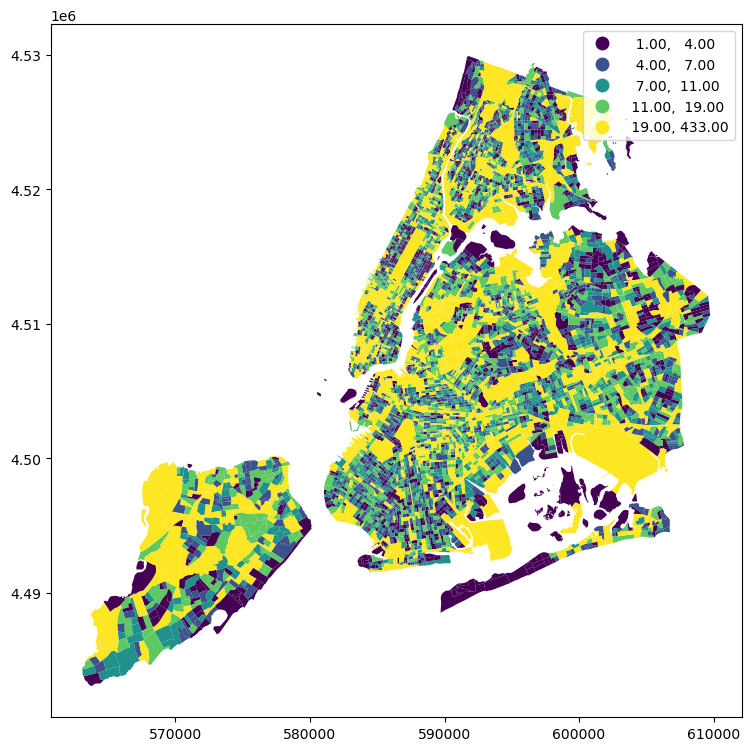

In [ ]:
fig, ax = plt.subplots(figsize=(15, 9))  # Set figure size

gdf_poly.plot(column="point_count",
                   cmap='viridis',
                   legend=True,
                   scheme="quantiles",
                   ax=ax)

# 3- Joining the points ==into==> polygons.
For this task, you can get the sum of a given column in the points for each polygon. 
For example total number of persons_injured. Each crash point may have more than 1 injured persons. Therefore, we can get the sum of a column for each polygon. 

In [ ]:
# Suppose the points have a numeric column named 'value'
# Calculate the sum of 'value' within each polygon
# value_sum = joined_gdf.groupby(joined_gdf.index)['value'].sum()
value_sum = joined_gdf.groupby(joined_gdf.index)['number_of_persons_injured'].sum()

# Add the summed values as a new column to the polygons
gdf_poly['value_sum'] = gdf_poly.index.map(value_sum).fillna(0)

### Plot the sum of the value

<AxesSubplot: >

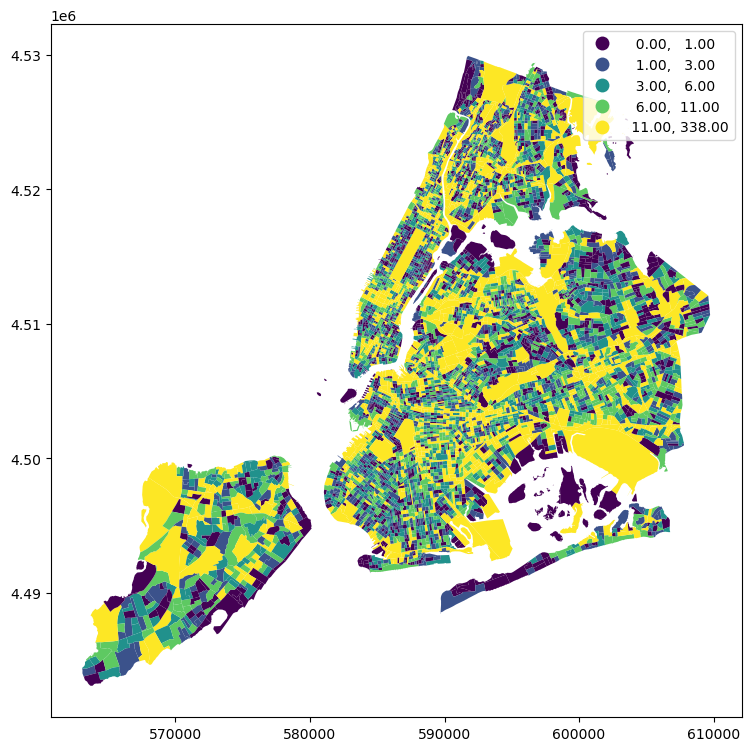

In [ ]:
fig, ax = plt.subplots(figsize=(15, 9))  # Set figure size

gdf_poly.plot(column="value_sum",
                   cmap='viridis',
                   legend=True,
                   scheme="quantiles",
                   ax=ax)